In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 29894 
    Total predicted counts          : 29654.39
    Total off counts                : 101973.00

    Total background counts         : 20394.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 2000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 7.47 s, sys: 55.4 ms, total: 7.53 s
Wall time: 7.53 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 29631 
    Total predicted counts          : 29672.79
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 29292 
    Total predicted counts          : 29715.59
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 29542 
    Total predicted counts          : 29634.39
    Total off counts                : 101873.00

    Total background counts         : 20374.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_29 

    Total counts                    : 29596 
    Total predicted counts          : 29508.39
    Total off counts                : 101243.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_62 

    Total counts                    : 29762 
    Total predicted counts          : 29581.99
    Total off counts                : 101611.00

    Total background counts         : 20322.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_63 

    Total counts                    : 29598 
    Total predicted counts          : 29509.99
    Total off counts                : 101251.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_93 

    Total counts                    : 29720 
    Total predicted counts          : 29518.79
    Total off counts                : 101295.00

    Total background counts         : 20259.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_94 

    Total counts                    : 30048 
    Total predicted counts          : 29519.79
    Total off counts                : 101300.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_127 

    Total counts                    : 29444 
    Total predicted counts          : 29551.59
    Total off counts                : 101459.00

    Total background counts         : 20291.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 29501 
    Total predicted counts          : 29422.99
    Total off counts                : 100816.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_159 

    Total counts                    : 29521 
    Total predicted counts          : 29512.59
    Total off counts                : 101264.00

    Total background counts         : 20252.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_160 

    Total counts                    : 29605 
    Total predicted counts          : 29528.19
    Total off counts                : 101342.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_183 

    Total counts                    : 29699 
    Total predicted counts          : 29488.99
    Total off counts                : 101146.00

    Total background counts         : 20229.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_184 

    Total counts                    : 29675 
    Total predicted counts          : 29641.19
    Total off counts                : 101907.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 29481 
    Total predicted counts          : 29521.19
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_203 

    Total counts                    : 29730 
    Total predicted counts          : 29622.79
    Total off counts                : 101815.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_224 

    Total counts                    : 29711 
    Total predicted counts          : 29568.59
    Total off counts                : 101544.00

    Total background counts         : 20308.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_225 

    Total counts                    : 29493 
    Total predicted counts          : 29543.59
    Total off counts                : 101419.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_244 

    Total counts                    : 29328 
    Total predicted counts          : 29475.19
    Total off counts                : 101077.00

    Total background counts         : 20215.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 29922 
    Total predicted counts          : 29526.59
    Total off counts                : 101334.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_264 

    Total counts                    : 29869 
    Total predicted counts          : 29572.99
    Total off counts                : 101566.00

    Total background counts         : 20313.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_265 

    Total counts                    : 29514 
    Total predicted counts          : 29628.99
    Total off counts                : 101846.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 29527 
    Total predicted counts          : 29631.79
    Total off counts                : 101860.00

    Total background counts         : 20372.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_286 

    Total counts                    : 29521 
    Total predicted counts          : 29515.59
    Total off counts                : 101279.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_307 

    Total counts                    : 29453 
    Total predicted counts          : 29576.99
    Total off counts                : 101586.00

    Total background counts         : 20317.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 29563 
    Total predicted counts          : 29422.99
    Total off counts                : 100816.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_327 

    Total counts                    : 29490 
    Total predicted counts          : 29481.39
    Total off counts                : 101108.00

    Total background counts         : 20221.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_328 

    Total counts                    : 29550 
    Total predicted counts          : 29503.59
    Total off counts                : 101219.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_348 

    Total counts                    : 29167 
    Total predicted counts          : 29472.99
    Total off counts                : 101066.00

    Total background counts         : 20213.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_349 

    Total counts                    : 29594 
    Total predicted counts          : 29651.19
    Total off counts                : 101957.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 29534 
    Total predicted counts          : 29601.39
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_369 

    Total counts                    : 29905 
    Total predicted counts          : 29645.39
    Total off counts                : 101928.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_389 

    Total counts                    : 29419 
    Total predicted counts          : 29637.39
    Total off counts                : 101888.00

    Total background counts         : 20377.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_390 

    Total counts                    : 29541 
    Total predicted counts          : 29517.59
    Total off counts                : 101289.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_406 

    Total counts                    : 29801 
    Total predicted counts          : 29542.39
    Total off counts                : 101413.00

    Total background counts         : 20282.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_407 

    Total counts                    : 29755 
    Total predicted counts          : 29604.19
    Total off counts                : 101722.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_422 

    Total counts                    : 29230 
    Total predicted counts          : 29543.19
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_423 

    Total counts                    : 29629 
    Total predicted counts          : 29680.59
    Total off counts                : 102104.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 29532 
    Total predicted counts          : 29622.79
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_441 

    Total counts                    : 29661 
    Total predicted counts          : 29624.99
    Total off counts                : 101826.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_462 

    Total counts                    : 29976 
    Total predicted counts          : 29494.19
    Total off counts                : 101172.00

    Total background counts         : 20234.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_463 

    Total counts                    : 29712 
    Total predicted counts          : 29493.59
    Total off counts                : 101169.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_478 

    Total counts                    : 29378 
    Total predicted counts          : 29621.19
    Total off counts                : 101807.00

    Total background counts         : 20361.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_479 

    Total counts                    : 29562 
    Total predicted counts          : 29526.59
    Total off counts                : 101334.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 29516 
    Total predicted counts          : 29600.99
    Total off counts                : 101706.00

    Total background counts         : 20341.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 29611 
    Total predicted counts          : 29572.59
    Total off counts                : 101564.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_513 

    Total counts                    : 29684 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts         : 20319.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_514 

    Total counts                    : 29370 
    Total predicted counts          : 29560.19
    Total off counts                : 101502.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_533 

    Total counts                    : 29388 
    Total predicted counts          : 29579.39
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_534 

    Total counts                    : 29830 
    Total predicted counts          : 29583.19
    Total off counts                : 101617.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_553 

    Total counts                    : 29789 
    Total predicted counts          : 29504.79
    Total off counts                : 101225.00

    Total background counts         : 20245.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_554 

    Total counts                    : 29510 
    Total predicted counts          : 29613.39
    Total off counts                : 101768.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_570 

    Total counts                    : 29516 
    Total predicted counts          : 29554.39
    Total off counts                : 101473.00

    Total background counts         : 20294.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_571 

    Total counts                    : 29504 
    Total predicted counts          : 29612.99
    Total off counts                : 101766.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_588 

    Total counts                    : 29385 
    Total predicted counts          : 29604.99
    Total off counts                : 101726.00

    Total background counts         : 20345.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 29705 
    Total predicted counts          : 29508.79
    Total off counts                : 101245.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_608 

    Total counts                    : 29572 
    Total predicted counts          : 29557.19
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_609 

    Total counts                    : 29474 
    Total predicted counts          : 29656.79
    Total off counts                : 101985.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_629 

    Total counts                    : 29482 
    Total predicted counts          : 29661.19
    Total off counts                : 102007.00

    Total background counts         : 20401.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_630 

    Total counts                    : 29355 
    Total predicted counts          : 29624.19
    Total off counts                : 101822.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_649 

    Total counts                    : 29691 
    Total predicted counts          : 29618.99
    Total off counts                : 101796.00

    Total background counts         : 20359.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_650 

    Total counts                    : 29514 
    Total predicted counts          : 29379.19
    Total off counts                : 100597.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_668 

    Total counts                    : 29804 
    Total predicted counts          : 29542.39
    Total off counts                : 101413.00

    Total background counts         : 20282.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_669 

    Total counts                    : 29670 
    Total predicted counts          : 29636.39
    Total off counts                : 101883.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_689 

    Total counts                    : 29494 
    Total predicted counts          : 29561.99
    Total off counts                : 101511.00

    Total background counts         : 20302.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_690 

    Total counts                    : 29677 
    Total predicted counts          : 29540.79
    Total off counts                : 101405.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_709 

    Total counts                    : 29807 
    Total predicted counts          : 29487.79
    Total off counts                : 101140.00

    Total background counts         : 20228.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_710 

    Total counts                    : 29467 
    Total predicted counts          : 29570.79
    Total off counts                : 101555.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_729 

    Total counts                    : 29642 
    Total predicted counts          : 29567.79
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_730 

    Total counts                    : 29550 
    Total predicted counts          : 29583.19
    Total off counts                : 101617.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_749 

    Total counts                    : 29255 
    Total predicted counts          : 29593.39
    Total off counts                : 101668.00

    Total background counts         : 20333.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_750 

    Total counts                    : 29747 
    Total predicted counts          : 29513.39
    Total off counts                : 101268.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_769 

    Total counts                    : 29472 
    Total predicted counts          : 29532.79
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_770 

    Total counts                    : 29706 
    Total predicted counts          : 29563.99
    Total off counts                : 101521.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_789 

    Total counts                    : 29356 
    Total predicted counts          : 29594.79
    Total off counts                : 101675.00

    Total background counts         : 20335.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_790 

    Total counts                    : 29708 
    Total predicted counts          : 29577.79
    Total off counts                : 101590.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_800 

    Total counts                    : 29615 
    Total predicted counts          : 29543.19
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_801 

    Total counts                    : 29764 
    Total predicted counts          : 29612.79
    Total off counts                : 101765.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_820 

    Total counts                    : 29397 
    Total predicted counts          : 29538.59
    Total off counts                : 101394.00

    Total background counts         : 20278.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_821 

    Total counts                    : 29504 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_840 

    Total counts                    : 29457 
    Total predicted counts          : 29617.79
    Total off counts                : 101790.00

    Total background counts         : 20358.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_841 

    Total counts                    : 29754 
    Total predicted counts          : 29574.59
    Total off counts                : 101574.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_861 

    Total counts                    : 29498 
    Total predicted counts          : 29571.19
    Total off counts                : 101557.00

    Total background counts         : 20311.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_862 

    Total counts                    : 29574 
    Total predicted counts          : 29548.19
    Total off counts                : 101442.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_881 

    Total counts                    : 29394 
    Total predicted counts          : 29599.19
    Total off counts                : 101697.00

    Total background counts         : 20339.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_882 

    Total counts                    : 29633 
    Total predicted counts          : 29593.19
    Total off counts                : 101667.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_901 

    Total counts                    : 29596 
    Total predicted counts          : 29517.79
    Total off counts                : 101290.00

    Total background counts         : 20258.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_902 

    Total counts                    : 29559 
    Total predicted counts          : 29568.79
    Total off counts                : 101545.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_923 

    Total counts                    : 29452 
    Total predicted counts          : 29539.79
    Total off counts                : 101400.00

    Total background counts         : 20280.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_924 

    Total counts                    : 29362 
    Total predicted counts          : 29485.19
    Total off counts                : 101127.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_943 

    Total counts                    : 29926 
    Total predicted counts          : 29493.79
    Total off counts                : 101170.00

    Total background counts         : 20234.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_944 

    Total counts                    : 29308 
    Total predicted counts          : 29574.99
    Total off counts                : 101576.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_962 

    Total counts                    : 29889 
    Total predicted counts          : 29581.19
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_963 

    Total counts                    : 29622 
    Total predicted counts          : 29580.59
    Total off counts                : 101604.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_982 

    Total counts                    : 29445 
    Total predicted counts          : 29468.99
    Total off counts                : 101046.00

    Total background counts         : 20209.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_983 

    Total counts                    : 29530 
    Total predicted counts          : 29594.79
    Total off counts                : 101675.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_1002 

    Total counts                    : 29207 
    Total predicted counts          : 29690.59
    Total off counts                : 102154.00

    Total background counts         : 20430.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1003 

    Total counts                    : 29583 
    Total predicted counts          : 29612.99
    Total off counts                : 101766.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1022 

    Total counts                    : 29453 
    Total predicted counts          : 29530.19
    Total off counts                : 101352.00

    Total background counts         : 20270.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1023 

    Total counts                    : 29665 
    Total predicted counts          : 29592.59
    Total off counts                : 101664.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1042 

    Total counts                    : 29648 
    Total predicted counts          : 29480.99
    Total off counts                : 101106.00

    Total background counts         : 20221.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1043 

    Total counts                    : 29323 
    Total predicted counts          : 29620.39
    Total off counts                : 101803.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1063 

    Total counts                    : 29511 
    Total predicted counts          : 29587.79
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1064 

    Total counts                    : 29478 
    Total predicted counts          : 29608.79
    Total off counts                : 101745.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1083 

    Total counts                    : 29595 
    Total predicted counts          : 29649.39
    Total off counts                : 101948.00

    Total background counts         : 20389.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1084 

    Total counts                    : 29494 
    Total predicted counts          : 29638.59
    Total off counts                : 101894.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1103 

    Total counts                    : 29594 
    Total predicted counts          : 29628.79
    Total off counts                : 101845.00

    Total background counts         : 20369.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1104 

    Total counts                    : 29775 
    Total predicted counts          : 29615.19
    Total off counts                : 101777.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1123 

    Total counts                    : 29297 
    Total predicted counts          : 29537.39
    Total off counts                : 101388.00

    Total background counts         : 20277.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1124 

    Total counts                    : 29383 
    Total predicted counts          : 29532.39
    Total off counts                : 101363.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1144 

    Total counts                    : 29587 
    Total predicted counts          : 29599.79
    Total off counts                : 101700.00

    Total background counts         : 20340.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1145 

    Total counts                    : 29740 
    Total predicted counts          : 29635.59
    Total off counts                : 101879.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1164 

    Total counts                    : 29305 
    Total predicted counts          : 29599.99
    Total off counts                : 101701.00

    Total background counts         : 20340.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1165 

    Total counts                    : 29640 
    Total predicted counts          : 29575.39
    Total off counts                : 101578.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1184 

    Total counts                    : 29486 
    Total predicted counts          : 29568.99
    Total off counts                : 101546.00

    Total background counts         : 20309.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1185 

    Total counts                    : 29621 
    Total predicted counts          : 29569.79
    Total off counts                : 101550.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1204 

    Total counts                    : 29709 
    Total predicted counts          : 29501.99
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1205 

    Total counts                    : 29635 
    Total predicted counts          : 29668.99
    Total off counts                : 102046.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1224 

    Total counts                    : 29811 
    Total predicted counts          : 29535.19
    Total off counts                : 101377.00

    Total background counts         : 20275.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1225 

    Total counts                    : 29965 
    Total predicted counts          : 29620.79
    Total off counts                : 101805.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1244 

    Total counts                    : 29771 
    Total predicted counts          : 29588.19
    Total off counts                : 101642.00

    Total background counts         : 20328.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1245 

    Total counts                    : 29392 
    Total predicted counts          : 29674.19
    Total off counts                : 102072.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1265 

    Total counts                    : 29553 
    Total predicted counts          : 29579.39
    Total off counts                : 101598.00

    Total background counts         : 20319.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1266 

    Total counts                    : 29385 
    Total predicted counts          : 29609.79
    Total off counts                : 101750.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 29337 
    Total predicted counts          : 29626.19
    Total off counts                : 101832.00

    Total background counts         : 20366.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1284 

    Total counts                    : 29901 
    Total predicted counts          : 29535.79
    Total off counts                : 101380.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1304 

    Total counts                    : 29760 
    Total predicted counts          : 29443.99
    Total off counts                : 100921.00

    Total background counts         : 20184.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1305 

    Total counts                    : 29765 
    Total predicted counts          : 29508.39
    Total off counts                : 101243.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1324 

    Total counts                    : 29314 
    Total predicted counts          : 29484.19
    Total off counts                : 101122.00

    Total background counts         : 20224.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1325 

    Total counts                    : 29508 
    Total predicted counts          : 29504.99
    Total off counts                : 101226.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1345 

    Total counts                    : 29469 
    Total predicted counts          : 29516.99
    Total off counts                : 101286.00

    Total background counts         : 20257.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1346 

    Total counts                    : 29454 
    Total predicted counts          : 29530.99
    Total off counts                : 101356.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1365 

    Total counts                    : 29524 
    Total predicted counts          : 29634.59
    Total off counts                : 101874.00

    Total background counts         : 20374.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1366 

    Total counts                    : 29460 
    Total predicted counts          : 29528.39
    Total off counts                : 101343.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1385 

    Total counts                    : 29603 
    Total predicted counts          : 29581.59
    Total off counts                : 101609.00

    Total background counts         : 20321.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1386 

    Total counts                    : 29891 
    Total predicted counts          : 29623.99
    Total off counts                : 101821.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1406 

    Total counts                    : 29638 
    Total predicted counts          : 29551.99
    Total off counts                : 101461.00

    Total background counts         : 20292.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1407 

    Total counts                    : 29661 
    Total predicted counts          : 29639.99
    Total off counts                : 101901.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1427 

    Total counts                    : 29550 
    Total predicted counts          : 29592.99
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1428 

    Total counts                    : 29456 
    Total predicted counts          : 29615.99
    Total off counts                : 101781.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1444 

    Total counts                    : 29406 
    Total predicted counts          : 29457.99
    Total off counts                : 100991.00

    Total background counts         : 20198.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1445 

    Total counts                    : 29830 
    Total predicted counts          : 29561.39
    Total off counts                : 101508.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1463 

    Total counts                    : 29798 
    Total predicted counts          : 29577.99
    Total off counts                : 101591.00

    Total background counts         : 20318.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1464 

    Total counts                    : 29695 
    Total predicted counts          : 29568.79
    Total off counts                : 101545.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1482 

    Total counts                    : 29649 
    Total predicted counts          : 29540.59
    Total off counts                : 101404.00

    Total background counts         : 20280.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1483 

    Total counts                    : 29923 
    Total predicted counts          : 29628.79
    Total off counts                : 101845.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1500 

    Total counts                    : 29519 
    Total predicted counts          : 29597.59
    Total off counts                : 101689.00

    Total background counts         : 20337.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1501 

    Total counts                    : 29752 
    Total predicted counts          : 29571.79
    Total off counts                : 101560.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1518 

    Total counts                    : 29892 
    Total predicted counts          : 29579.99
    Total off counts                : 101601.00

    Total background counts         : 20320.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1519 

    Total counts                    : 29552 
    Total predicted counts          : 29527.99
    Total off counts                : 101341.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1538 

    Total counts                    : 29653 
    Total predicted counts          : 29556.39
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1539 

    Total counts                    : 29656 
    Total predicted counts          : 29504.79
    Total off counts                : 101225.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1558 

    Total counts                    : 29363 
    Total predicted counts          : 29564.19
    Total off counts                : 101522.00

    Total background counts         : 20304.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1559 

    Total counts                    : 29486 
    Total predicted counts          : 29575.79
    Total off counts                : 101580.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1577 

    Total counts                    : 29326 
    Total predicted counts          : 29614.59
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1578 

    Total counts                    : 29403 
    Total predicted counts          : 29690.39
    Total off counts                : 102153.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1597 

    Total counts                    : 29859 
    Total predicted counts          : 29610.19
    Total off counts                : 101752.00

    Total background counts         : 20350.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1598 

    Total counts                    : 29472 
    Total predicted counts          : 29609.99
    Total off counts                : 101751.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1616 

    Total counts                    : 29496 
    Total predicted counts          : 29543.39
    Total off counts                : 101418.00

    Total background counts         : 20283.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1617 

    Total counts                    : 29892 
    Total predicted counts          : 29516.39
    Total off counts                : 101283.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1633 

    Total counts                    : 29189 
    Total predicted counts          : 29624.99
    Total off counts                : 101826.00

    Total background counts         : 20365.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1634 

    Total counts                    : 29413 
    Total predicted counts          : 29548.59
    Total off counts                : 101444.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1652 

    Total counts                    : 29406 
    Total predicted counts          : 29468.79
    Total off counts                : 101045.00

    Total background counts         : 20209.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1653 

    Total counts                    : 29430 
    Total predicted counts          : 29621.79
    Total off counts                : 101810.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1671 

    Total counts                    : 29686 
    Total predicted counts          : 29610.99
    Total off counts                : 101756.00

    Total background counts         : 20351.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1672 

    Total counts                    : 29596 
    Total predicted counts          : 29639.59
    Total off counts                : 101899.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1687 

    Total counts                    : 29766 
    Total predicted counts          : 29607.59
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1688 

    Total counts                    : 29474 
    Total predicted counts          : 29532.79
    Total off counts                : 101365.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1706 

    Total counts                    : 29678 
    Total predicted counts          : 29684.99
    Total off counts                : 102126.00

    Total background counts         : 20425.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1707 

    Total counts                    : 29816 
    Total predicted counts          : 29589.99
    Total off counts                : 101651.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1722 

    Total counts                    : 29530 
    Total predicted counts          : 29545.79
    Total off counts                : 101430.00

    Total background counts         : 20286.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1723 

    Total counts                    : 29548 
    Total predicted counts          : 29561.19
    Total off counts                : 101507.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1737 

    Total counts                    : 29394 
    Total predicted counts          : 29538.39
    Total off counts                : 101393.00

    Total background counts         : 20278.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1738 

    Total counts                    : 29861 
    Total predicted counts          : 29500.79
    Total off counts                : 101205.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1754 

    Total counts                    : 29296 
    Total predicted counts          : 29579.19
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1755 

    Total counts                    : 29453 
    Total predicted counts          : 29662.39
    Total off counts                : 102013.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1771 

    Total counts                    : 29425 
    Total predicted counts          : 29580.59
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1772 

    Total counts                    : 29600 
    Total predicted counts          : 29536.39
    Total off counts                : 101383.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1784 

    Total counts                    : 29599 
    Total predicted counts          : 29478.59
    Total off counts                : 101094.00

    Total background counts         : 20218.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1785 

    Total counts                    : 29764 
    Total predicted counts          : 29474.99
    Total off counts                : 101076.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1799 

    Total counts                    : 29652 
    Total predicted counts          : 29487.79
    Total off counts                : 101140.00

    Total background counts         : 20228.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1800 

    Total counts                    : 29847 
    Total predicted counts          : 29542.19
    Total off counts                : 101412.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1815 

    Total counts                    : 29319 
    Total predicted counts          : 29559.79
    Total off counts                : 101500.00

    Total background counts         : 20300.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1816 

    Total counts                    : 29606 
    Total predicted counts          : 29584.99
    Total off counts                : 101626.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1829 

    Total counts                    : 29532 
    Total predicted counts          : 29492.39
    Total off counts                : 101163.00

    Total background counts         : 20232.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1830 

    Total counts                    : 29478 
    Total predicted counts          : 29683.39
    Total off counts                : 102118.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1845 

    Total counts                    : 29637 
    Total predicted counts          : 29538.59
    Total off counts                : 101394.00

    Total background counts         : 20278.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1846 

    Total counts                    : 29701 
    Total predicted counts          : 29468.79
    Total off counts                : 101045.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1863 

    Total counts                    : 29527 
    Total predicted counts          : 29481.19
    Total off counts                : 101107.00

    Total background counts         : 20221.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1864 

    Total counts                    : 29693 
    Total predicted counts          : 29459.19
    Total off counts                : 100997.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1879 

    Total counts                    : 29434 
    Total predicted counts          : 29509.19
    Total off counts                : 101247.00

    Total background counts         : 20249.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1880 

    Total counts                    : 29523 
    Total predicted counts          : 29491.99
    Total off counts                : 101161.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1895 

    Total counts                    : 29497 
    Total predicted counts          : 29593.99
    Total off counts                : 101671.00

    Total background counts         : 20334.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1896 

    Total counts                    : 29407 
    Total predicted counts          : 29555.59
    Total off counts                : 101479.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1909 

    Total counts                    : 29468 
    Total predicted counts          : 29584.59
    Total off counts                : 101624.00

    Total background counts         : 20324.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1910 

    Total counts                    : 29503 
    Total predicted counts          : 29628.79
    Total off counts                : 101845.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 29665 
    Total predicted counts          : 29574.79
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1923 

    Total counts                    : 29740 
    Total predicted counts          : 29573.99
    Total off counts                : 101571.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 29620 
    Total predicted counts          : 29681.19
    Total off counts                : 102107.00

    Total background counts         : 20421.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 0.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 29602 
    Total predicted counts          : 29535.39
    Total off counts                : 101378.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1951 

    Total counts                    : 29750 
    Total predicted counts          : 29562.39
    Total off counts                : 101513.00

    Total background counts         : 20302.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1952 

    Total counts                    : 29393 
    Total predicted counts          : 29497.39
    Total off counts                : 101188.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1966 

    Total counts                    : 29803 
    Total predicted counts          : 29530.79
    Total off counts                : 101355.00

    Total background counts         : 20271.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1967 

    Total counts                    : 29541 
    Total predicted counts          : 29517.79
    Total off counts                : 101290.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1983 

    Total counts                    : 29444 
    Total predicted counts          : 29574.59
    Total off counts                : 101574.00

    Total background counts         : 20314.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1984 

    Total counts                    : 29284 
    Total predicted counts          : 29437.79
    Total off counts                : 100890.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1999 

    Total counts                    : 29649 
    Total predicted counts          : 29482.39
    Total off counts                : 101113.00

    Total background counts         : 20222.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



Text(0, 0.5, 'No. of observations')

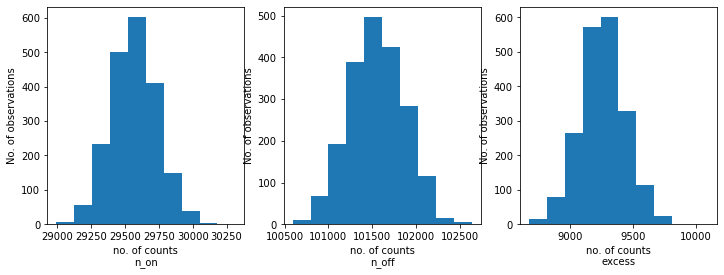

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 11min 38s, sys: 3.82 s, total: 11min 42s
Wall time: 12min 42s


In [15]:
results

[{'index': 2.285078513860973,
  'amplitude': 1.0707193841268212e-12,
  'lambda_': 1.7549757404234874},
 {'index': 2.1996324583985576,
  'amplitude': 1.2851232177832685e-12,
  'lambda_': 1.997248139660084},
 {'index': 2.2150850927687675,
  'amplitude': 1.3692600994164495e-12,
  'lambda_': 2.20388042489302},
 {'index': 2.1744685095939555,
  'amplitude': 1.462793993258135e-12,
  'lambda_': 2.2474813108859273},
 {'index': 2.243873278458896,
  'amplitude': 1.2666459861422052e-12,
  'lambda_': 1.9900955664082853},
 {'index': 2.224555841721795,
  'amplitude': 1.2790952762632778e-12,
  'lambda_': 2.0144251668081212},
 {'index': 2.3291540173955845,
  'amplitude': 9.829721114495055e-13,
  'lambda_': 1.6931848673905465},
 {'index': 2.1918609482837472,
  'amplitude': 1.4022834966072621e-12,
  'lambda_': 2.1229102661191366},
 {'index': 2.23233981236747,
  'amplitude': 1.2093207915318237e-12,
  'lambda_': 1.8886782502405552},
 {'index': 2.1711397774344117,
  'amplitude': 1.487073324677619e-12,
  'la

index: 2.2174506616369514 += 0.0529536198874143


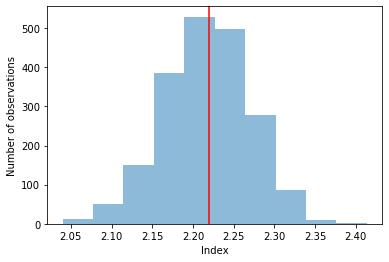

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.311418315075546e-12 += 1.9046638297871103e-13


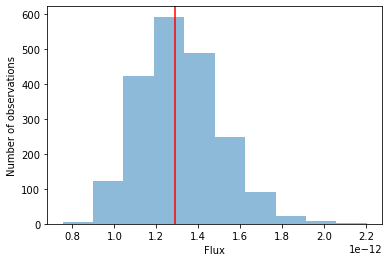

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 2.0137968564785513 += 0.21070490415611645


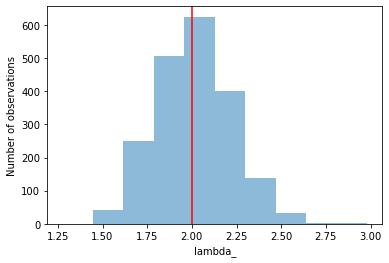

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")